# CDS 201: Group 5
Names: Nahom Abraha, Su-Ah Lee, Nick Stares

## Imports

In [1]:
#how to give the node preferences: [-1,1] -> [liberal, conservative]

#expected simulation outcome: it'll mirror the empircal model (assuming equality) 
#or everything will mellow out if there are no external shit
#otherwise, smaller networks will have less change across ticks
#ie, also seeing network resiliance 
import networkx as nx
import matplotlib as plt
from random import seed
import random 
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Annimation Imports

%matplotlib notebook
%matplotlib inline
import random
import pylab
from matplotlib.pyplot import pause
pylab.ion()

# Methods

In [2]:
#added
#sum the weight of everything
def summation(z):
    totcon = 0
    totlib = 0
    totmod = 0

    for n in z.nodes():
        pref = z.node[n]['weight']
        if -0.1 <= pref <= 0.1:
            totmod += pref
        elif pref > 0:
            totcon += pref
        else: 
            totlib += pref
    return totcon, totlib, totmod

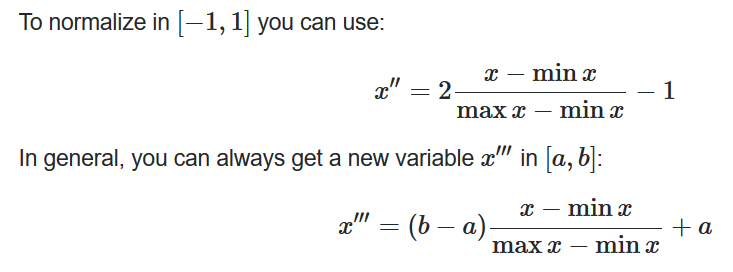
source: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1

In [3]:
def normalize(G): # normalizing weights between -0.9 to 0.9
    Normalized = copy.deepcopy(G)   
    list_of_tup = list(G.nodes.data('weight'))
    pref_list = []
    for tup in list_of_tup:
        pref_list.append(tup[1])
    
    min_pref = min(pref_list)
    max_pref = max(pref_list)
    
    for i in G.nodes():
        pref = G.node[i]['weight']
        pref_normal = (2*(0.9)*(pref - min_pref)/(max_pref - min_pref)) - 0.9
        Normalized.node[i]['weight'] = pref_normal
    
    return Normalized

In [4]:
 def update_network1(z):
    G = copy.deepcopy(z)    
    for i in z.nodes():
        pref = z.node[i]['weight']
        all_pulls = 0
        for j in z.neighbors(i):
            #essentially: (your pref minus my pref) * you-me link weight
            other = z.node[j]['weight'] # another person's political preference
            link = z[i][j]['weight'] # link weight
            all_pulls += (other-pref)*link
            
        pref += all_pulls 
        G.node[i]['weight'] = pref # Updating the weight of each node in the network 
    Normalized = normalize(G)
    return Normalized

# Updating a Network Considering All Factors
**The function below takes into account, link weight, political preference of others, and the number of people
per group. This means a group with a higher number of people is more likely to affect your political
preference than another group with smaller number of people. Also, a person with a stronger political preference is more likely to affect another person's political preference than those with weaker political preference.**

In [5]:
def all_factors(z):
    G = copy.deepcopy(z)  
    
# First: counting how many people belong to each of the three political categories    
    dem = 0 # number of democrats
    rep = 0 # number of republicans 
    neu = 0 # number of neutrals
    for i in z.nodes():
        for j in z.neighbors(i):
            value = z.node[j]['weight']
            if value > 0:
                rep += 1
            elif value < 0:
                dem += 1
            else:
                neu += 1
#`````````````````````````````````````````````````````````````````````````````````````````````````````

# Second: calculating the proportion of total population belonging to a specific group
    total = dem + rep + neu
    dem_prop = dem/total # Of all the people you interact with, how many are democrats
    rep_prop = rep/total # Of all the people you interact with, how many are republicans
    neu_prop = neu/total # Of all the people you interact with, how many are neutrals

#``````````````````````````````````````````````````````````````````````````````````````````````````````` 

# Third: updating the political preference of a person taking into account the link weight,
#        the political preference of others, and the number of people in each of the 
#        the three groups: democrats, republicans, and neutrals

    dem_pull = 0 # the amount by which democrats change your political preference 
    rep_pull = 0 # the amount by which democrats change your political preference 
    neu_pull = 0 # the amount by which democrats change your political preference 
    
    for i in z.nodes():
        pref = z.node[i]['weight'] # a given person's political preference
        other = z.node[j]['weight'] # another person's political preference
        for j in z.neighbors(i):     
            link = z[i][j]['weight'] # the weight of link between two people
            temp = (other-pref)*link
            if other > 0:
                rep_pull += rep_prop*temp
            elif other < 0:
                dem_pull += dem_prop*temp
            else:
                neu_pull += neu_prop*temp
                
        pref += (rep_pull + dem_pull + neu_pull) 
        G.node[i]['weight'] = pref # Updating the weight of each node in the network 
    Normalized = normalize(G)
    return Normalized

In [6]:
# Categorizing nodes 
def categorize(z):
    dem = []
    rep = []
    moderate = []
    for n in z.nodes():
        pref = z.node[n]['weight']
        if  -0.1 <= pref <= 0.1:
            moderate.append(n)
        elif pref > 0:
            rep.append(n)
        else: 
            dem.append(n)
    return dem, rep, moderate

In [7]:
def coloredEdges(z):
    friends = []
    family = []
    spousal = []
    for i in z.nodes():
        for j in z.neighbors(i):
            connection = z[i][j]['weight']
            if connection == 0.7: #family
                family.append([i,j])
            elif connection == 0.67: #friends
                friends.append([i,j])
            elif connection == 0.6: #spousal
                spousal.append([i,j])
                
    return friends, family, spousal

In [8]:
#drawing the graph
def display(z):
    #get the lists to put things in color
    dem, rep, mod = categorize(z)
    friends, family, spousal = coloredEdges(z)
    #labels
    nodeLabels = {} #for nodes
    for i in z.nodes():
        nodeLabels[i] = i
        
    #the actual drawing
    pos=nx.spring_layout(z) 
    #uncomment below to force a size for the canvas
    #plt.rcParams['figure.figsize'] = (10,10)
    nx.draw(z, pos, node_size = 10)
    nx.draw_networkx_nodes(z,pos, dem, node_color = 'b') #liberals are blue
    nx.draw_networkx_nodes(z,pos, rep, node_color = 'r') #conservative are red
    nx.draw_networkx_nodes(z,pos, mod, node_color = 'purple') #mods are yellow
    nx.draw_networkx_edges(z, pos, width=1.0, alpha=0.5) # all the edges
    nx.draw_networkx_edges(z, pos, friends, edge_color= 'green') #friends are green
    nx.draw_networkx_labels(z, pos, nodeLabels, font_size=16) #labels for the nodes 
    

In [9]:
def PopCount(z):
    #Population Count:
    print('Total Participants: ', len(z.nodes()))
    dem, rep, mod = categorize(z)
    print('Conservatives: ', len(rep))
    print('Liberals: ', len(dem))
    print('Moderates: ', len(mod))
    friends, family, spousal = coloredEdges(z)
    print('Friend Connections: ', len(friends))
    
    totcon, totlib, totmod = summation(z)
    print('Total Weight of Conservative: ', totcon)
    print('Total Weight of Liberals: ', totlib)
    print('Total Weight of Moderates: ', totmod)

## The Sample Network 

In [10]:
seed(1)
### variables

#links:
famW = 0.7#family weigh : 0.7
friW= 0.67 #friends weigh: 0.67 -> given
SW = 0.6#spousal weigh : 0.6

#network z
z = nx.Graph()
#change uniform to [-1, 0] for liberals and [0,1] for conservatives
z.add_node(1, weight = random.uniform(-0.9,0.9) )
z.add_node(2, weight = random.uniform(-0.9,0.9) )
z.add_node(3, weight = random.uniform(-0.9,0.9) )
z.add_node(4, weight = random.uniform(-0.9,0.9))
z.add_edge(1, 2, weight = SW)
z.add_edge(1, 3, weight = famW)
z.add_edge(1, 4, weight = famW)
z.add_edge(2, 3, weight = famW)
z.add_edge(2, 4, weight = famW)
z.add_edge(3, 4, weight = famW)

[(1, -0.6581443605976778), (2, 0.6253807264870189), (3, 0.4747943141579053), (4, -0.44087575366904097)]
Total Participants:  4
Conservatives:  2
Liberals:  2
Moderates:  0
Friend Connections:  0
Total Weight of Conservative:  1.1001750406449242
Total Weight of Liberals:  -1.0990201142667186
Total Weight of Moderates:  0


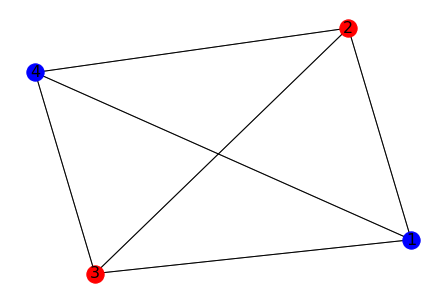

In [11]:
print(z.nodes.data('weight'))
display(z)
PopCount(z)

[(1, 0.9), (2, -0.9), (3, -0.7749218739198409), (4, 0.6697182862200207)]
Total Participants:  4
Conservatives:  2
Liberals:  2
Moderates:  0
Friend Connections:  0
Total Weight of Conservative:  1.5697182862200207
Total Weight of Liberals:  -1.6749218739198408
Total Weight of Moderates:  0


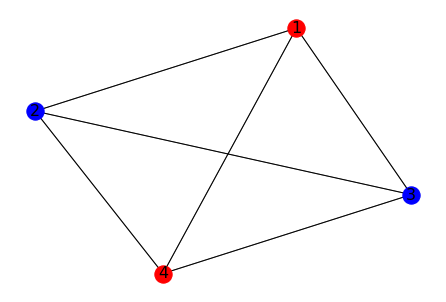

In [12]:
v2 = update_network1(z)
print(v2.nodes.data('weight'))
PopCount(v2)
display(v2)

In [13]:
PopCount(z)

Total Participants:  4
Conservatives:  2
Liberals:  2
Moderates:  0
Friend Connections:  0
Total Weight of Conservative:  1.1001750406449242
Total Weight of Liberals:  -1.0990201142667186
Total Weight of Moderates:  0


# Small World Network Sample

In [14]:
#set seed to 1 for my sake
watts = nx.watts_strogatz_graph(10,2,0.5, 1) #number of node, degree, prob of re-wire, seed
#node-weights:
for i in range(10):
    watts.node[i]['weight'] = random.uniform(-0.9,0.9)
#link weights:
watts[0][5]['weight'] = friW
watts[9][5]['weight'] = friW
watts[9][8]['weight'] = friW
watts[0][4]['weight'] = friW
watts[4][3]['weight'] = famW
watts[7][3]['weight'] = famW
watts[7][6]['weight'] = famW
watts[4][6]['weight'] = famW
watts[2][6]['weight'] = SW
watts[1][7]['weight'] = SW

#draw
#display(watts)

# Small-World Network of Friends Generating Function

In [15]:
def small_world_friends(n,k,p,s):
    F = nx.watts_strogatz_graph(n,k,p,s) #number of node, degree, prob of re-wire, seed
    
    #node-weights:
    for i in range(n):
        F.node[i]['weight'] = random.uniform(-0.9,0.9)
    
    #link weights:
    for i in F:
        for j in F:
            if F.has_edge(i,j):
                F[i][j]['weight'] = friW
    
    return F


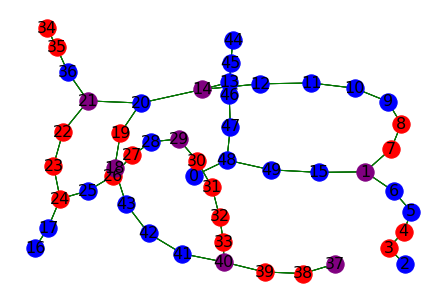

In [16]:
F = small_world_friends(50,3,0.3,1) # a network of only friends
F_update = all_factors(F)

display(F_update)

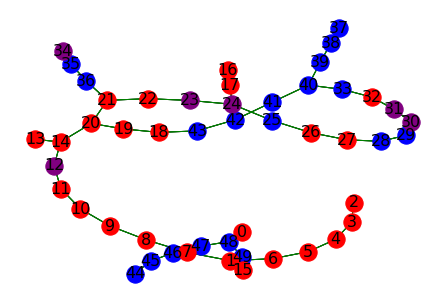

In [17]:
F_update1 = all_factors(F_update)
display(F_update1)

In [18]:
PopCount(F_update)

Total Participants:  50
Conservatives:  18
Liberals:  25
Moderates:  7
Friend Connections:  100
Total Weight of Conservative:  8.431894092959487
Total Weight of Liberals:  -9.517900766800453
Total Weight of Moderates:  0.10524171695287932


source: https://www.youtube.com/watch?v=GIywmJbGH-8

# Real Time Plots

In [19]:
def real_time_plot1(z,n):
    import matplotlib.pyplot as plt
    import time
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'

    G = copy.deepcopy(z)

    total = [0]*n
    dem = [0]*n
    rep = [0]*n
    mod = [0]*n

    for i in range(n):
        N = update_network1(G)
        G = N


        d,r,m = categorize(N)
        dem[i] = len(d)
        rep[i] = len(r)
        mod[i] = len(m)
        total[i] = len(d) + len(r) + len(m)
        
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    d = []
    r = []
    m = []
    t = []
    x = []
    plt.title('Population Change Over Time')
    plt.xlabel('time in (weeks)')
    plt.ylabel('number of people')
    for i in range(len(total)):
        d.append(dem[i])
        r.append(rep[i])
        m.append(mod[i])
        t.append(total[i])
        x.append(i)
        ax.plot(x,d, 'blue')
        ax.plot(x,r, 'red')
        ax.plot(x,m, 'purple')
        ax.plot(x,t, 'black')
        
    
        fig.canvas.draw()
        time.sleep(0.1)


<IPython.core.display.Javascript object>


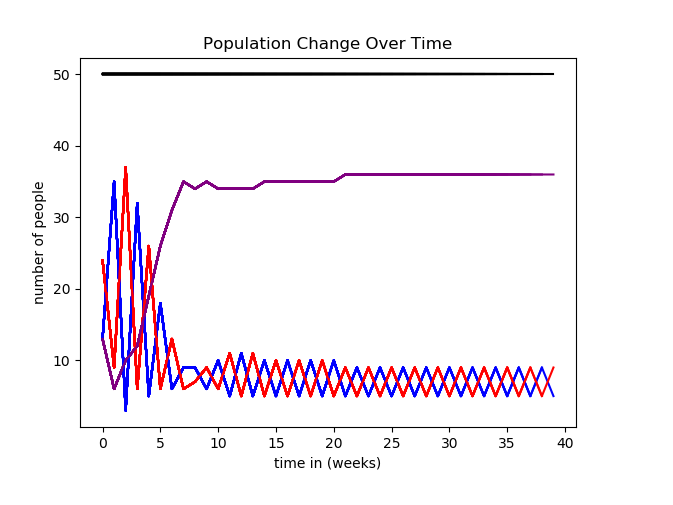

In [20]:
F = small_world_friends(50,2,0.3,1) # a network of only friends
real_time_plot1(F,40)

In [21]:
def real_time_plot2(z,n):
    import matplotlib.pyplot as plt
    import time
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'

    G = copy.deepcopy(z)

    total = [0]*n
    dem = [0]*n
    rep = [0]*n
    mod = [0]*n

    for i in range(n):
        N = all_factors(G)
        G = N


        d,r,m = categorize(N)
        dem[i] = len(d)
        rep[i] = len(r)
        mod[i] = len(m)
        total[i] = len(d) + len(r) + len(m)
        
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    d = []
    r = []
    m = []
    t = []
    x = []
    plt.title('Population Change Over Time')
    plt.xlabel('time in (weeks)')
    plt.ylabel('number of people')
    for i in range(len(total)):
        d.append(dem[i])
        r.append(rep[i])
        m.append(mod[i])
        t.append(total[i])
        x.append(i)
        ax.plot(x,d, 'blue')
        ax.plot(x,r, 'red')
        ax.plot(x,m, 'purple')
        ax.plot(x,t, 'black')
        
    
        fig.canvas.draw()
        time.sleep(0.1)


<IPython.core.display.Javascript object>


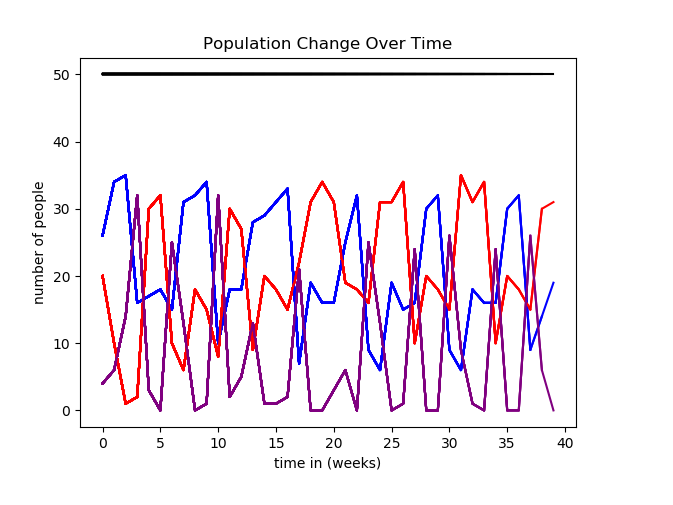

In [22]:
F = small_world_friends(50,2,0.3,1) # a network of only friends
real_time_plot2(F,40)

In [23]:
def real_time_plot3(z,n): # Real-Time Plot of Absolute Total Political Preference for Each Group
    import matplotlib.pyplot as plt
    import time
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'

    G = copy.deepcopy(z)

    total = [0]*n
    dem = [0]*n
    rep = [0]*n
    mod = [0]*n

    for i in range(n):
        N = update_network1(G)
        G = N


        r,d,m = summation(N)
        dem[i] = d
        rep[i] = r
        mod[i] = m
        total[i] = d + r + m
        
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    d = []
    r = []
    m = []
    t = []
    x = []
    plt.title('Total Political Preference Change Over Time')
    plt.xlabel('time in (weeks)')
    plt.ylabel('Sum of preference')
    for i in range(len(total)):
        d.append(dem[i])
        r.append(rep[i])
        m.append(mod[i])
        t.append(total[i])
        x.append(i)
        ax.plot(x,d, 'blue')
        ax.plot(x,r, 'red')
        ax.plot(x,m, 'purple')
        
    
        fig.canvas.draw()
        time.sleep(0.1)


In [24]:
def real_time_plot4(z,n): # Real-Time Plot of Proportional Total Political Preference for Each Group
    import matplotlib.pyplot as plt
    import time
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'

    G = copy.deepcopy(z)

    total = [0]*n
    dem = [0]*n
    rep = [0]*n
    mod = [0]*n

    for i in range(n):
        N = all_factors(G)
        G = N


        r,d,m = summation(N)
        dem[i] = d
        rep[i] = r
        mod[i] = m
        total[i] = d + r + m
        
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    d = []
    r = []
    m = []
    t = []
    x = []
    plt.title('Total Political Preference Change Over Time')
    plt.xlabel('time in (weeks)')
    plt.ylabel('Sum of preference')
    for i in range(len(total)):
        d.append(dem[i])
        r.append(rep[i])
        m.append(mod[i])
        t.append(total[i])
        x.append(i)
        ax.plot(x,d, 'blue')
        ax.plot(x,r, 'red')
        ax.plot(x,m, 'purple')
        
    
        fig.canvas.draw()
        time.sleep(0.1)


<IPython.core.display.Javascript object>


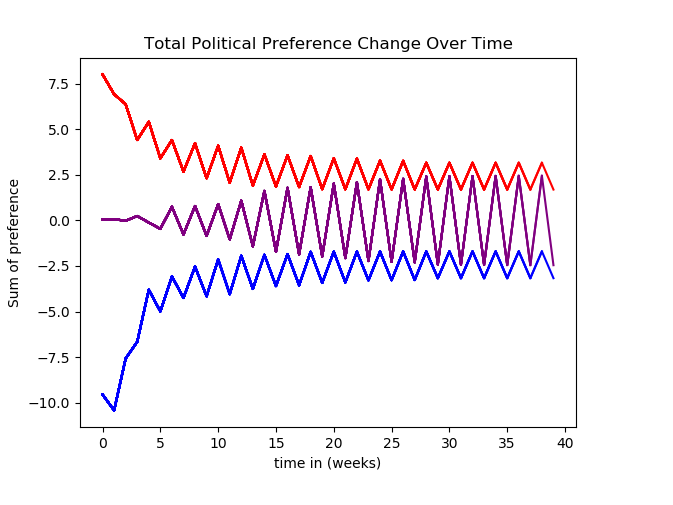

In [25]:
F = small_world_friends(50,2,0.3,1) # a network of only friends
real_time_plot3(F,40)

<IPython.core.display.Javascript object>


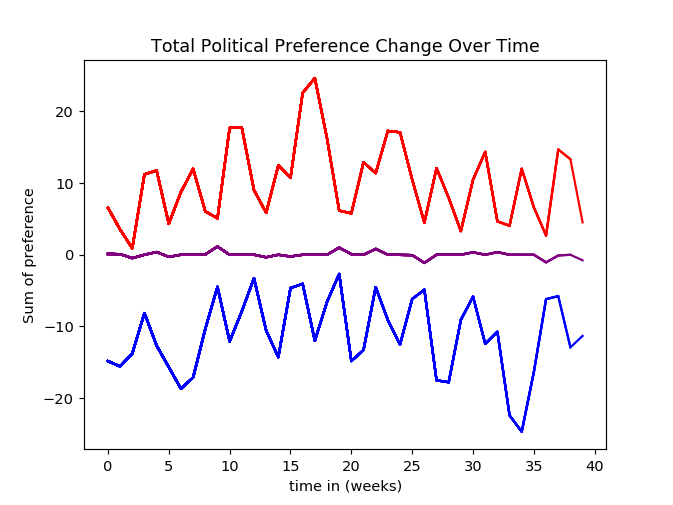

In [26]:
F = small_world_friends(50,2,0.3,1) # a network of only friends
real_time_plot4(F,40)